In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import hddm
from sys import platform
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

ImportError: libgfortran.so.3: cannot open shared object file: No such file or directory

In [10]:
print(hddm.__version__)

0.6.0


In [11]:
if platform == 'linux':
    home = '/home/krista/'
elif platform == 'darwin': 
    home = '/Users/Krista/'

In [12]:
all_sim_data = hddm.load_csv(home + 'Dropbox/loki_0/simple_rt_experiment_probabilityC/analysis/aggregated_data/probC_sim_learning_signals_processed.csv')
sim_plotting_data = all_sim_data
#use target choice as response 
#include correct target choice as stimulus 
all_sim_data = all_sim_data.rename(index=str, columns={"acc": "response"
                                                       })
all_sim_data = all_sim_data[['response', 'rt', 'cond', 'subj_idx', 'ideal_B', 'cpp']] 
# #use target-based belief in reward difference (b_t0 - b_t1)
all_sim_data = all_sim_data.rename(index=str, columns={'ideal_B': 'B'})
all_sim_data = all_sim_data[(all_sim_data.rt<0.6)]
all_sim_data.reset_index(drop=True, inplace=True)

In [13]:
all_sim_data.head()

,response,rt,cond,subj_idx,B,cpp
0,False,0.172,hc,0,-0.306135,0.019881
1,False,0.172,hc,0,-0.139394,0.018539
2,False,0.172,hc,0,-0.027685,0.268538
3,False,0.172,hc,0,-0.804363,0.035630
4,False,0.172,hc,0,0.064818,0.785155


In [14]:
#get all combinations of a,t,v,z 
from itertools import combinations

targets = ['a', 't', 'v', 'z']
param_pairs = list(combinations(targets, 2))
param_triples = list(combinations(targets, 3))

print(param_pairs)
print(len(param_pairs))

[('a', 't'), ('a', 'v'), ('a', 'z'), ('t', 'v'), ('t', 'z'), ('v', 'z')]
6


In [15]:
model_dict = {'a_t': param_pairs[0], 'a_v': param_pairs[1],
'a_z': param_pairs[2], 't_v': param_pairs[3], 
't_z': param_pairs[4], 'v_z': param_pairs[5], 'a': targets[0], 't': targets[1],
             'v': targets[2], 'z': targets[3]}

In [16]:
n_samples, n_burn = 3000, 500

## Flat model

In [17]:
flat_m=hddm.HDDMStimCoding(all_sim_data, bias=True, stim_col='stimulus', p_outlier=0.05, split_param='v')
flat_m.find_starting_values()
flat_m.sample(n_samples, burn=n_burn)

KeyError: 'stimulus'

## All pairs.

In [135]:
a_t_m=hddm.HDDMStimCoding(all_sim_data,stim_col='stimulus', p_outlier=0.05, split_param='v', depends_on={'a': 'cond', 't': 'cond'}, bias=True)
a_t_m.find_starting_values()
a_t_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 1885.2 sec

In [126]:
a_v_t_m=hddm.HDDM(all_sim_data, depends_on={'a': 'cond', 'v': 'cond', 't': 'cond'}, bias=True)
a_v_t_m.find_starting_values()
a_v_t_m.sample(n_samples, burn=n_burn)

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 861.7 sec

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [133]:
sum(np.isnan(all_sim_data.rt))

0

In [149]:
hv_a = sim_plotting_data.gen_bound.loc[sim_plotting_data.cond == 'hv']
lv_a = sim_plotting_data.gen_bound.loc[sim_plotting_data.cond == 'lv']

In [168]:
sim_plotting_data.loc[sim_plotting_data.acc == 1, 'gen_drift_flipped'] = abs(sim_plotting_data.loc[sim_plotting_data.acc == 1, 'gen_drift'])

In [284]:
sim_plotting_data.loc[sim_plotting_data.cond == 'lc', 'verbose_cond'] = 'low conflict'
sim_plotting_data.loc[sim_plotting_data.cond == 'hc', 'verbose_cond'] = 'high conflict'

sim_plotting_data.loc[sim_plotting_data.cond == 'lv', 'verbose_cond'] = 'low volatility'
sim_plotting_data.loc[sim_plotting_data.cond == 'hv', 'verbose_cond'] = 'high volatility'

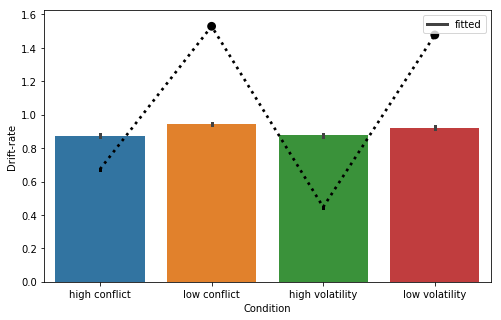

In [319]:
plt.figure(figsize=(8,5))
sns.barplot(x="verbose_cond",y="gen_drift_flipped", data=sim_plotting_data, ci=95, n_boot=1000,units="ID", 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, label='simulated', )
sns.pointplot(x="condition",y="v", data=fitted_df, ci=95, n_boot=1000, 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, linestyles='dotted', label='fitted', color='black',)
# plt.ylim(0.5,.8)
plt.ylabel('Drift-rate')
plt.xlabel('Condition')
plt.legend(['fitted'])
plt.savefig('drift_sim_fit_gen.pdf')

In [177]:
group_traces = a_v_m.get_group_traces()
a_hc, a_hv, a_lc, a_lv = group_traces.iloc[:,0], group_traces.iloc[:,1], group_traces.iloc[:,2], group_traces.iloc[:,3]

v_hc, v_hv, v_lc, v_lv = group_traces.iloc[:,7], group_traces.iloc[:,8], group_traces.iloc[:,9], group_traces.iloc[:,10]

In [191]:
group_traces.mean()

a(hc)      0.714025
a(hv)      0.746709
a(lc)      0.701957
a(lv)      0.676501
a_std      0.168919
t          0.197735
t_std      0.190378
v(hc)      0.674021
v(hv)      0.447528
v(lc)      1.528887
v(lv)      1.477075
v_std      0.355483
z_std      0.109369
z_trans    0.144313
dtype: float64

In [287]:
a = pd.concat([a_hc, a_hv, a_lc, a_lv]).values
v = pd.concat([v_hc, v_hv, v_lc, v_lv]).values
n_conditions=4
condition = np.repeat(['high conflict', 'high volatility', 'low conflict', 'low volatility'], len(a_lc))
d = {'a': a, 'v': v, 'condition': condition}
fitted_df = pd.DataFrame(data=d)

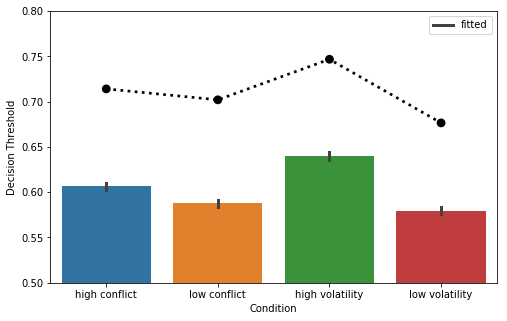

In [317]:
plt.figure(figsize=(8,5))

sns.barplot(x="verbose_cond",y="gen_bound", data=sim_plotting_data, ci=95, n_boot=1000,units="ID", 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, label='simulated' )
sns.pointplot(x="condition",y="a", data=fitted_df, ci=95, n_boot=1000, 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, linestyles='dotted', label='fitted', color='black')
plt.ylim(0.5,.8)
plt.legend(['fitted'])
plt.ylabel('Decision Threshold')
plt.xlabel('Condition')
plt.savefig('thresh_sim_fit_gen.pdf')

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(x="verbose_cond",y="gen_drift_flipped", data=sim_plotting_data, ci=95, n_boot=1000,units="ID", 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, label='simulated', )
sns.hist(x="condition",y="v", data=fitted_df, ci=95, n_boot=1000, 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, linestyles='dotted', label='fitted', color='black',)
# plt.ylim(0.5,.8)
plt.ylabel('Drift-rate')
plt.xlabel('Condition')
plt.legend(['fitted'])
plt.savefig('drift_sim_fit_gen.pdf')

KeyboardInterrupt: 

In [137]:
a_z_m=hddm.HDDMStimCoding(all_sim_data, stim_col='stimulus', p_outlier=0.05, split_param='v', depends_on={'a': 'cond', 'z': 'cond'}, bias=True)
a_z_m.find_starting_values()
a_z_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 2122.6 sec

In [138]:
#fit hddm model according to above 
t_v_m=hddm.HDDMStimCoding(all_sim_data, stim_col='stimulus',p_outlier=0.05,  split_param='v', depends_on={'t': 'cond', 'v': 'cond'}, bias=True)
t_v_m.find_starting_values()
t_v_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 2286.8 sec

In [139]:
#fit hddm model according to above 
t_z_m=hddm.HDDMStimCoding(all_sim_data, stim_col='stimulus', p_outlier=0.05, split_param='v', depends_on={'t': 'cond', 'z': 'cond'}, bias=True)
t_z_m.find_starting_values()
t_z_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 2298.4 sec

In [140]:
#fit hddm model according to above 
v_z_m=hddm.HDDMStimCoding(all_sim_data, stim_col='stimulus', p_outlier=0.05, split_param='v', depends_on={'v': 'cond', 'z': 'cond'}, bias=True)
v_z_m.find_starting_values()
v_z_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 2140.9 sec

## All single parameters. 

In [141]:
a_m=hddm.HDDMStimCoding(all_sim_data, split_param='v',p_outlier=0.05, stim_col='stimulus', depends_on={'a': 'cond'}, bias=True)
a_m.find_starting_values()
a_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 2074.6 sec

In [142]:
t_m=hddm.HDDMStimCoding(all_sim_data, split_param='v',p_outlier=0.05, stim_col='stimulus', depends_on={'t': 'cond'}, bias=True)
t_m.find_starting_values()
t_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 2248.6 sec

In [143]:
v_m=hddm.HDDMStimCoding(all_sim_data, split_param='v',p_outlier=0.05, stim_col='stimulus', depends_on={'v': 'cond'}, bias=True)
v_m.find_starting_values()
v_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 2015.3 sec

In [144]:
z_m=hddm.HDDMStimCoding(all_sim_data, split_param='v',p_outlier=0.05,stim_col='stimulus',  depends_on={'z': 'cond'}, bias=True)
z_m.find_starting_values()
z_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 2071.4 sec

In [145]:
atv_m=hddm.HDDMStimCoding(all_sim_data, stim_col='stimulus', p_outlier=0.05,split_param='v',depends_on={'a': 'cond','t':'cond', 
                                                                                      'v': 'cond'}, bias=True)
atv_m.find_starting_values()
atv_m.sample(n_samples)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


 [-----------------100%-----------------] 3001 of 3000 complete in 1952.8 sec

In [146]:
atz_m=hddm.HDDMStimCoding(all_sim_data, stim_col='stimulus', p_outlier=0.05, split_param='v',depends_on={'a': 'cond','t':'cond', 
                                                                                      'z': 'cond'}, bias=True)
atz_m.find_starting_values()
atz_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 1840.3 sec

In [148]:
avz_m=hddm.HDDMStimCoding(all_sim_data, stim_col='stimulus', p_outlier=0.05, split_param='v',depends_on={'a': 'cond','v':'cond', 
                                                                                      'z': 'cond'}, bias=True)
avz_m.find_starting_values()
avz_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 1724.9 sec

In [149]:
tvz_m=hddm.HDDMStimCoding(all_sim_data, stim_col='stimulus', p_outlier=0.05, split_param='v',depends_on={'t': 'cond','v':'cond', 
                                                                                      'z': 'cond'}, bias=True)
tvz_m.find_starting_values()
tvz_m.sample(n_samples, burn=n_burn)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 1790.6 sec

In [150]:
atvz_m=hddm.HDDMStimCoding(all_sim_data, stim_col='stimulus',p_outlier=0.05, split_param='v',depends_on={'a': 'cond','t': 'cond','v':'cond', 
                                                                                      'z': 'cond'}, bias=True)
atvz_m.find_starting_values()
atvz_m.sample(n_samples)

/home/krista/anaconda3/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 1782.5 sec

In [151]:
single_param_dics = [a_m.dic, t_m.dic, v_m.dic, z_m.dic]
dual_param_dics = [a_t_m.dic, a_v_m.dic, a_z_m.dic, t_v_m.dic, t_z_m.dic, 
                  v_z_m.dic]

In [156]:
dual_param_dics

[-852344.69998776424,
 -917024.73534050235,
 -1447809.6629537719,
 -937761.55588701437,
 -1349557.683345668,
 -1395414.2613191777]

In [152]:
min(single_param_dics) == v_m.dic

False

In [117]:
single_param_dics

[-286239.75603291602,
 -287427.54687998933,
 -287583.58770549443,
 -285303.37113992142]

In [119]:
dual_param_dics

[nan,
 -286845.84518419346,
 -285979.3969776067,
 -290438.52330108819,
 nan,
 -287691.54729412677]

In [97]:
#send text when the script is done
from twilio.rest import Client
accountSid = 'AC2832bdf83bb5a2f150686d323b7a3440'
authToken = '70363f4f104ac88b8aefc6b7886fb989'
twilioClient = Client(accountSid, authToken)
myTwilioNumber = 6095422252
destCellPhone = 6094242780
myMessage = twilioClient.messages.create(body = "fits are done for simulated data.",
                                         from_=myTwilioNumber, to=destCellPhone)